In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import numpy as np
import tensorflow as tf

In [2]:
df = pd.read_csv(os.path.join('data', 'stock_market_data.csv'), delimiter=',', usecols=['Date','Open','High','Low','Close','Volume','OpenInt'])

In [3]:
df = df.loc[:, ['Open', 'High', 'Low', 'Volume', 'Close']]
print(df.shape)
df.head()

(14059, 5)


,Open,High,Low,Volume,Close
0,6.4130,6.4130,6.3378,467056,6.3378
1,6.3378,6.3963,6.3378,350294,6.3963
2,6.3963,6.3963,6.3295,314365,6.3295
3,6.3211,6.3211,6.1958,440112,6.2041
4,6.2041,6.2041,6.0373,655676,6.0870


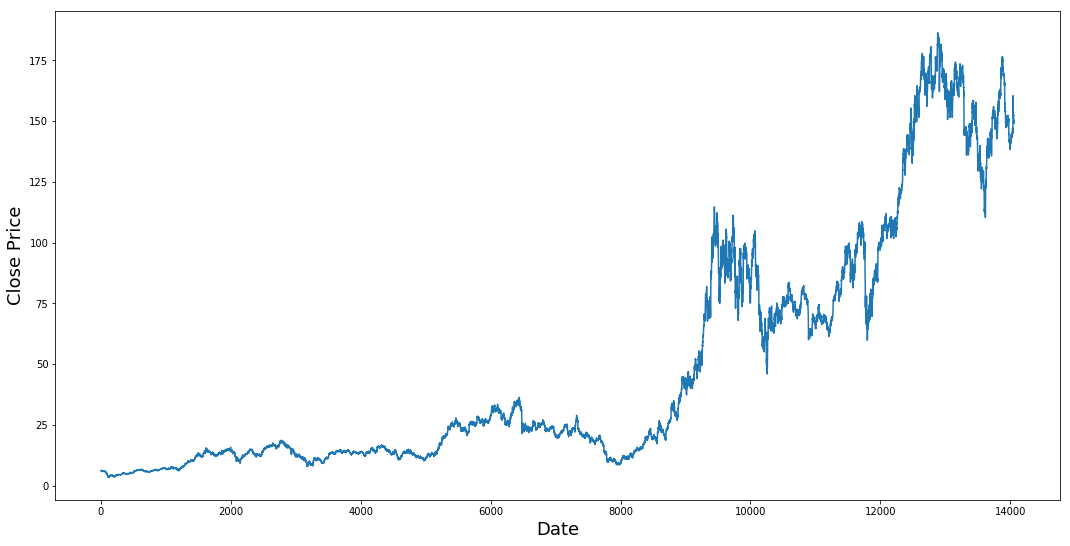

In [4]:
plt.figure(figsize = (18, 9))
plt.plot(range(df.shape[0]), df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.show()

In [5]:
tf.set_random_seed(777)

In [6]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

In [7]:
sequence_length = 7
data_dim = 5
hidden_size = 10
output_dim = 1
learning_rate = 0.1
iterations = 500

In [8]:
xy = MinMaxScaler(df.as_matrix())

In [9]:
x = xy
y = xy[:, [-1]]

In [10]:
dataX = []
dataY = []
for i in range(0, len(y) - sequence_length):
    _x = x[i:i + sequence_length]
    _y = y[i + sequence_length]
    
    dataX.append(_x)
    dataY.append(_y)

In [11]:
train_size = int(len(dataX) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:len(dataY)])

In [12]:
X = tf.placeholder(tf.float32, [None, sequence_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

In [13]:
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_size, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

Y_pred = tf.contrib.layers.fully_connected(outputs[:,-1], output_dim, activation_fn=None)

loss = tf.reduce_sum(tf.square(Y_pred - Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [14]:
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

0 Cost: 333.18527
100 Cost: 0.24933386
200 Cost: 0.19602141
300 Cost: 0.17410648
400 Cost: 0.16300839
RMSE:  0.03995268


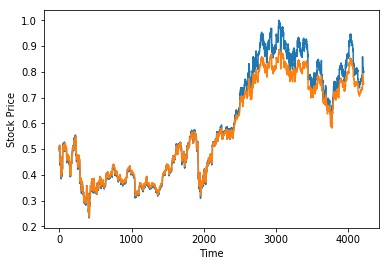

In [15]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(iterations):
        _, l = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
        if i % 100 == 0 or i == 0:
            print(i, 'Cost:', l)
    
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
    print('RMSE: ', rmse_val)
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.show()